In [1]:
import math
import torch
import gpytorch
import numpy as np
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 50

# Generating Data

In [3]:
train_x1 = torch.linspace(0, 1, 101)
train_x2 = torch.linspace(0, 1, 101)
train_y_matrix = torch.FloatTensor(train_x1.size()[0], train_x2.size()[0])
for i, x1 in enumerate(train_x1):
    for j, x2 in enumerate(train_x2):
        train_y_matrix[i, j] = torch.sin((x1+x2) * (2 * math.pi)) + torch.randn(1) * math.sqrt(0.04)

## Visualising Data

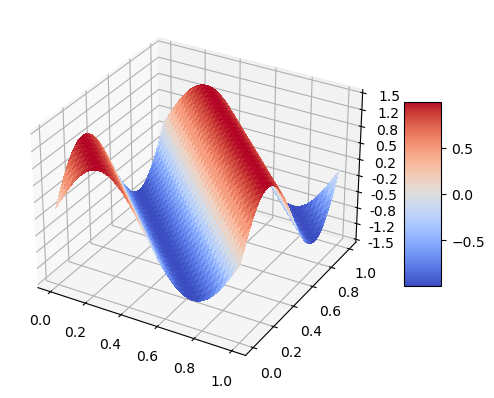

In [4]:
X1, X2 = np.meshgrid(train_x1, train_x2)
Z = np.sin(2 * math.pi * (X1 + X2))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X1, X2, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_zlim(-1.5, 1.5)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter('{x:.01f}')

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

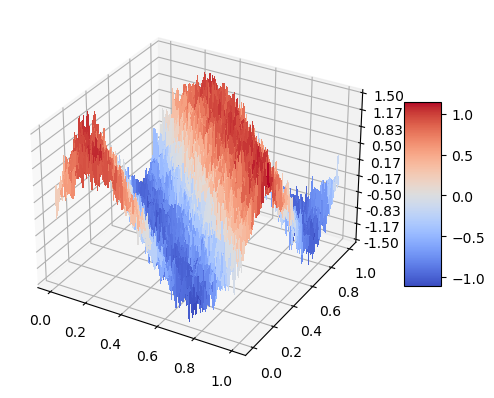

In [5]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X1, X2, train_y_matrix, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_zlim(-1.5, 1.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

# Training Model

### Reformatting Data

In [6]:
train_x = torch.FloatTensor(train_x1.size()[0]*train_x2.size()[0], 2)
train_y = torch.FloatTensor(train_x1.size()[0]*train_x2.size()[0])
for i, x1 in enumerate(train_x1):
    for j, x2 in enumerate(train_x2):
        k = (train_x2.size()[0]*i)+j
        train_x[k,0] = x1
        train_x[k,1] = x2
        train_y[k] = train_y_matrix[i, j]

In [7]:
test_x1 = torch.linspace(0, 1, 51)
test_x2 = torch.linspace(0, 1, 51)
test_x = torch.FloatTensor(test_x1.size()[0]*test_x2.size()[0], 2)
test_y = torch.FloatTensor(test_x1.size()[0]*test_x2.size()[0])
for i, x1 in enumerate(test_x1):
    for j, x2 in enumerate(test_x2):
        k = (test_x2.size()[0]*i)+j
        test_x[k,0] = x1
        test_x[k,1] = x2
        test_y[k] = np.sin(2*math.pi*(x1+x2))

In [8]:
X1, X2 = np.meshgrid(test_x1, test_x2)

## Squared Exponential Kernel

In [9]:
class SE_ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(SE_ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
se_model = SE_ExactGPModel(train_x, train_y, likelihood)

In [10]:
# Find optimal model hyperparameters
se_model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(se_model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

se_train_loss = []

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, se_model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = se_model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    se_train_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        se_model.covar_module.base_kernel.lengthscale.item(),
        se_model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.914   lengthscale: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.875   lengthscale: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.831   lengthscale: 0.598   noise: 0.598
Iter 4/50 - Loss: 0.778   lengthscale: 0.555   noise: 0.554
Iter 5/50 - Loss: 0.716   lengthscale: 0.514   noise: 0.513
Iter 6/50 - Loss: 0.651   lengthscale: 0.475   noise: 0.473
Iter 7/50 - Loss: 0.590   lengthscale: 0.438   noise: 0.436
Iter 8/50 - Loss: 0.537   lengthscale: 0.404   noise: 0.402
Iter 9/50 - Loss: 0.491   lengthscale: 0.374   noise: 0.369
Iter 10/50 - Loss: 0.448   lengthscale: 0.347   noise: 0.338
Iter 11/50 - Loss: 0.408   lengthscale: 0.323   noise: 0.310
Iter 12/50 - Loss: 0.368   lengthscale: 0.303   noise: 0.283
Iter 13/50 - Loss: 0.330   lengthscale: 0.286   noise: 0.259
Iter 14/50 - Loss: 0.291   lengthscale: 0.271   noise: 0.236
Iter 15/50 - Loss: 0.254   lengthscale: 0.258   noise: 0.215
Iter 16/50 - Loss: 0.217   lengthscale: 0.247   noise: 0.196
Iter 17/50 - Loss: 0.180   length

In [11]:
# Get into evaluation (predictive posterior) mode
se_model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    se_observed_pred = likelihood(se_model(test_x))

In [12]:
se_observed_y = se_observed_pred.mean
se_observed_y_matrix = se_observed_y.reshape(51, 51)

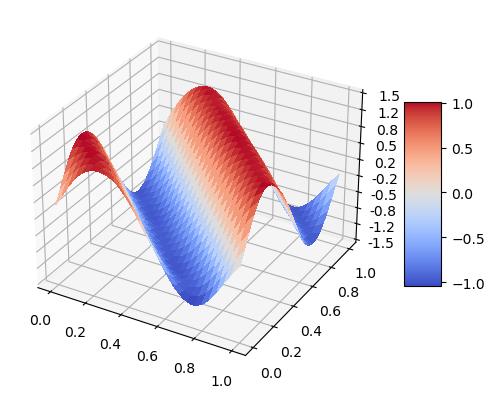

In [13]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X1, X2, se_observed_y_matrix, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_zlim(-1.5, 1.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.01f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [14]:
nlpd = gpytorch.metrics.negative_log_predictive_density(se_observed_pred, test_y)
msll = gpytorch.metrics.mean_standardized_log_loss(se_observed_pred, test_y)
mse = gpytorch.metrics.mean_squared_error(se_observed_pred, test_y, squared=True)
mae = gpytorch.metrics.mean_absolute_error(se_observed_pred, test_y)


print(f'Negative Log Predictive Density: {nlpd:.4f}, \nMean Standardized Log Loss: {msll:.4f}, \nMean Squared Error: {mse:.4f}, \nMean Absolute Error: {mae:.4f}')

Negative Log Predictive Density: -0.7744, 
Mean Standardized Log Loss: -0.7732, 
Mean Squared Error: 0.0003, 
Mean Absolute Error: 0.0131


## Matern Kernel

In [15]:
class Matern_ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(Matern_ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
matern_model = Matern_ExactGPModel(train_x, train_y, likelihood)

In [16]:
# Find optimal model hyperparameters
matern_model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(matern_model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

matern_train_loss = []

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, matern_model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = matern_model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    matern_train_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        matern_model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.795   noise: 0.693
Iter 2/50 - Loss: 0.754   noise: 0.644
Iter 3/50 - Loss: 0.715   noise: 0.598
Iter 4/50 - Loss: 0.676   noise: 0.554
Iter 5/50 - Loss: 0.638   noise: 0.513
Iter 6/50 - Loss: 0.601   noise: 0.474
Iter 7/50 - Loss: 0.563   noise: 0.437
Iter 8/50 - Loss: 0.525   noise: 0.403
Iter 9/50 - Loss: 0.488   noise: 0.370
Iter 10/50 - Loss: 0.451   noise: 0.340
Iter 11/50 - Loss: 0.414   noise: 0.312
Iter 12/50 - Loss: 0.376   noise: 0.286
Iter 13/50 - Loss: 0.340   noise: 0.262
Iter 14/50 - Loss: 0.303   noise: 0.240
Iter 15/50 - Loss: 0.266   noise: 0.219
Iter 16/50 - Loss: 0.229   noise: 0.200
Iter 17/50 - Loss: 0.193   noise: 0.182
Iter 18/50 - Loss: 0.158   noise: 0.166
Iter 19/50 - Loss: 0.123   noise: 0.152
Iter 20/50 - Loss: 0.090   noise: 0.138
Iter 21/50 - Loss: 0.059   noise: 0.126
Iter 22/50 - Loss: 0.027   noise: 0.115
Iter 23/50 - Loss: -0.003   noise: 0.105
Iter 24/50 - Loss: -0.031   noise: 0.095
Iter 25/50 - Loss: -0.057   noise: 0.087
Iter 2

In [17]:
# Get into evaluation (predictive posterior) mode
matern_model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    matern_observed_pred = likelihood(matern_model(test_x))

In [18]:
matern_observed_y = matern_observed_pred.mean
matern_observed_y_matrix = matern_observed_y.reshape(51, 51)

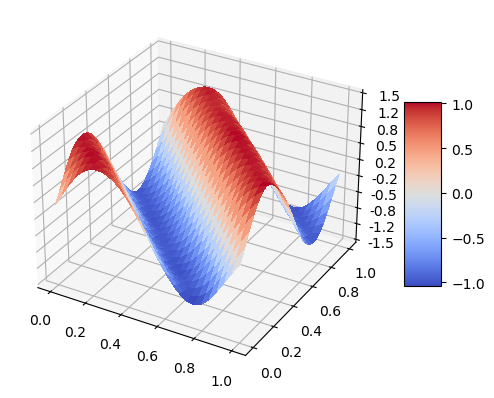

In [19]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X1, X2, matern_observed_y_matrix, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_zlim(-1.5, 1.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.01f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [20]:
nlpd = gpytorch.metrics.negative_log_predictive_density(matern_observed_pred, test_y)
msll = gpytorch.metrics.mean_standardized_log_loss(matern_observed_pred, test_y)
mse = gpytorch.metrics.mean_squared_error(matern_observed_pred, test_y, squared=True)
mae = gpytorch.metrics.mean_absolute_error(matern_observed_pred, test_y)


print(f'Negative Log Predictive Density: {nlpd:.4f}, \nMean Standardized Log Loss: {msll:.4f}, \nMean Squared Error: {mse:.4f}, \nMean Absolute Error: {mae:.4f}')

Negative Log Predictive Density: -0.7713, 
Mean Standardized Log Loss: -0.7693, 
Mean Squared Error: 0.0004, 
Mean Absolute Error: 0.0150


## Rational Quadratic Kernel

In [21]:
class RQ_ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(RQ_ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
rq_model = RQ_ExactGPModel(train_x, train_y, likelihood)

In [22]:
# Find optimal model hyperparameters
rq_model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(rq_model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

rq_train_loss = []

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, rq_model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = rq_model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    rq_train_loss.append(loss.item())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   alpha: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        rq_model.covar_module.base_kernel.lengthscale.item(),
        rq_model.covar_module.base_kernel.alpha.item(),
        rq_model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/50 - Loss: 0.818   lengthscale: 0.693   alpha: 0.693   noise: 0.693
Iter 2/50 - Loss: 0.769   lengthscale: 0.644   alpha: 0.644   noise: 0.644
Iter 3/50 - Loss: 0.724   lengthscale: 0.599   alpha: 0.599   noise: 0.598
Iter 4/50 - Loss: 0.681   lengthscale: 0.557   alpha: 0.558   noise: 0.554
Iter 5/50 - Loss: 0.641   lengthscale: 0.520   alpha: 0.522   noise: 0.513
Iter 6/50 - Loss: 0.602   lengthscale: 0.487   alpha: 0.491   noise: 0.474
Iter 7/50 - Loss: 0.564   lengthscale: 0.458   alpha: 0.464   noise: 0.437
Iter 8/50 - Loss: 0.526   lengthscale: 0.433   alpha: 0.441   noise: 0.403
Iter 9/50 - Loss: 0.489   lengthscale: 0.411   alpha: 0.422   noise: 0.370
Iter 10/50 - Loss: 0.450   lengthscale: 0.392   alpha: 0.406   noise: 0.340
Iter 11/50 - Loss: 0.412   lengthscale: 0.376   alpha: 0.392   noise: 0.312
Iter 12/50 - Loss: 0.375   lengthscale: 0.362   alpha: 0.381   noise: 0.286
Iter 13/50 - Loss: 0.338   lengthscale: 0.350   alpha: 0.372   noise: 0.262
Iter 14/50 - Loss: 0.

In [23]:
# Get into evaluation (predictive posterior) mode
rq_model.eval()
likelihood.eval()

# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    rq_observed_pred = likelihood(rq_model(test_x))

In [24]:
rq_observed_y = rq_observed_pred.mean
rq_observed_y_matrix = rq_observed_y.reshape(51, 51)

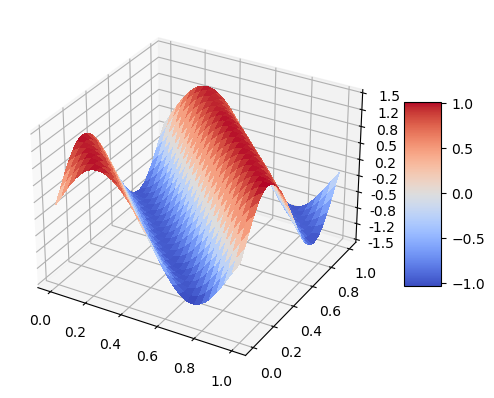

In [25]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X1, X2, rq_observed_y_matrix, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_zlim(-1.5, 1.5)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.01f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [26]:
nlpd = gpytorch.metrics.negative_log_predictive_density(rq_observed_pred, test_y)
msll = gpytorch.metrics.mean_standardized_log_loss(rq_observed_pred, test_y)
mse = gpytorch.metrics.mean_squared_error(rq_observed_pred, test_y, squared=True)
mae = gpytorch.metrics.mean_absolute_error(rq_observed_pred, test_y)


print(f'Negative Log Predictive Density: {nlpd:.4f}, \nMean Standardized Log Loss: {msll:.4f}, \nMean Squared Error: {mse:.4f}, \nMean Absolute Error: {mae:.4f}')

Negative Log Predictive Density: -0.7747, 
Mean Standardized Log Loss: -0.7737, 
Mean Squared Error: 0.0003, 
Mean Absolute Error: 0.0127


## Loss Curves

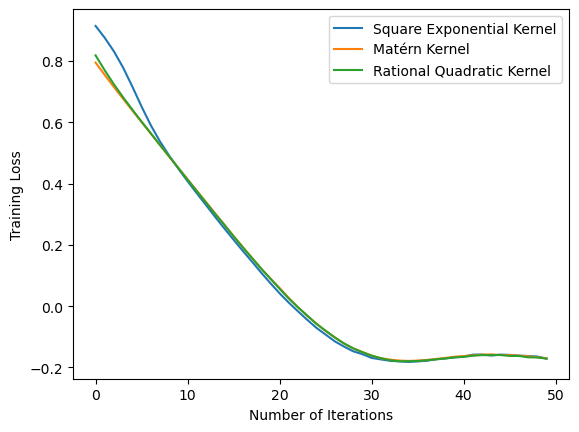

In [27]:
plt.plot(se_train_loss)
plt.plot(matern_train_loss)
plt.plot(rq_train_loss)
plt.xlabel('Number of Iterations')
plt.ylabel('Training Loss')
plt.legend(['Square Exponential Kernel', 'Matérn Kernel', 'Rational Quadratic Kernel'])
plt.show()